In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
training_dir = "D:\Python\mlmed2025\data\\training_set"
test_dir = "D:\Python\mlmed2025\data\\test_set"

image_data = []
filenames = []
target_size = (800, 540)

In [4]:
for filename in sorted(os.listdir(training_dir)):
    if filename.endswith(".png"):
        image = cv2.imread(os.path.join(training_dir, filename), cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, target_size)
        image_data.append(image)
        filenames.append(filename)

In [5]:
image_data = np.array(image_data)
print("Image data shape:", image_data.shape)

Image data shape: (1998, 540, 800)


In [6]:
csv_data = pd.read_csv("D:\Python\mlmed2025\data\\training_set_pixel_size_and_HC.csv")

X = image_data[::2]
Y = image_data[1::2]

IMG_WIDTH = 128
IMG_HEIGHT = 128

In [7]:
X_resize = np.zeros((len(X), IMG_HEIGHT, IMG_WIDTH))
Y_resize = np.zeros((len(Y), IMG_HEIGHT, IMG_WIDTH))

for i in range(len(X)):
    X_resize[i] = cv2.resize(X[i], (IMG_WIDTH, IMG_HEIGHT))
    Y_resize[i] = cv2.resize(Y[i], (IMG_WIDTH, IMG_HEIGHT))
    
X_train, X_test, Y_train, Y_test, hc_train, hc_test, pixel_train, pixel_test = train_test_split(
    X_resize, Y_resize,
    csv_data['head circumference (mm)'], csv_data['pixel size(mm)'],
    test_size=0.2, random_state=4, shuffle=True
)


In [8]:
def unet_segmentation_model(input_size=(128, 128, 1)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c4)
    d1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)

    u2 = layers.UpSampling2D((2, 2))(d1)
    d2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)

    u3 = layers.UpSampling2D((2, 2))(d2)
    d3 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u3)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(d3)

    model = keras.Model(inputs, outputs)
    return model

model = unet_segmentation_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
X_train_input = X_train.reshape(-1, 128, 128, 1) / 255.0
Y_train_input = Y_train.reshape(-1, 128, 128, 1) / 255.0
X_test_input = X_test.reshape(-1, 128, 128, 1) / 255.0
Y_test_input = Y_test.reshape(-1, 128, 128, 1) / 255.0

In [ ]:
history = model.fit(X_train_input, Y_train_input,
                    validation_data=(X_test_input, Y_test_input),
                    batch_size=16,
                    epochs=10)

In [ ]:
preds_test = model.predict(X_test_input)
preds_test_binary = (preds_test > 0.1).astype(np.uint8)
y_test_binary = (Y_test_input > 0.1).astype(np.uint8)

In [12]:
def compute_circumference(mask):
    mask = mask.squeeze().astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        return cv2.arcLength(contours[0], closed=True)
    return 0

hc_true_mm = [compute_circumference(y_test_binary[i]) for i in range(len(y_test_binary))]
hc_pred_mm = [compute_circumference(preds_test_binary[i]) for i in range(len(preds_test_binary))]

hc_true_mm = np.array(hc_true_mm)
hc_pred_mm = np.array(hc_pred_mm)

mae_hc = np.mean(np.abs(hc_pred_mm - hc_true_mm))
mre_hc = np.mean([abs(pred - true) / true * 100 if true > 0 else 0
                  for pred, true in zip(hc_pred_mm, hc_true_mm)])

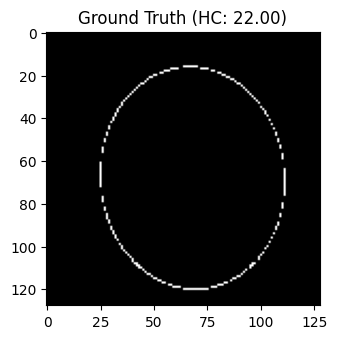

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title(f"Ground Truth (HC: {hc_true_mm[1]:.2f})")
plt.imshow(y_test_binary[1].squeeze(), cmap='gray')

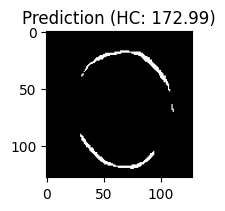

In [23]:
plt.subplot(1, 3, 2)
plt.title(f"Prediction (HC: {hc_pred_mm[1]:.2f})")
plt.imshow(preds_test_binary[1].squeeze(), cmap='gray')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


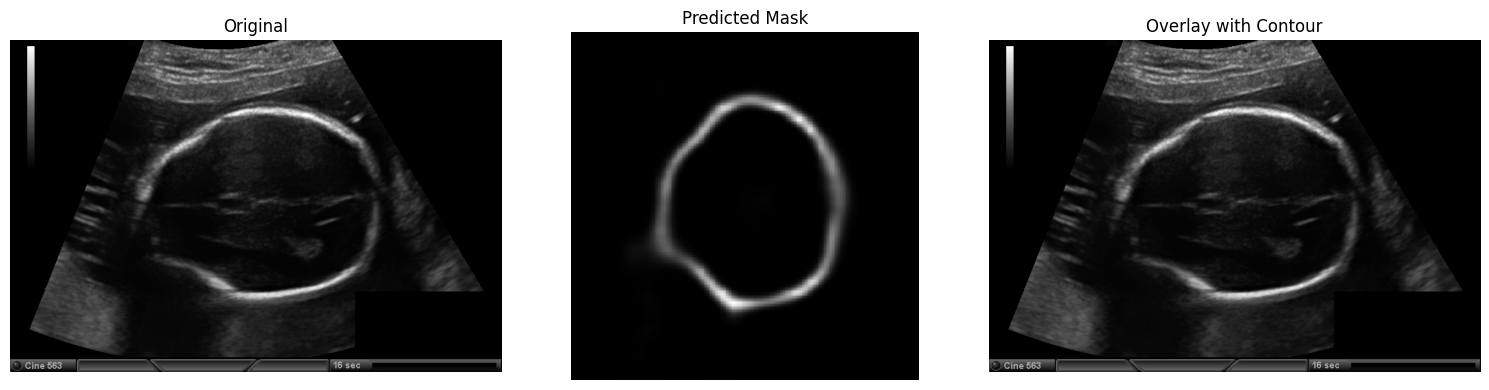

In [24]:
import random

test_files = [f for f in os.listdir(test_dir) if "_HC.png" in f]
random_file = random.choice(test_files)
image_path = os.path.join(test_dir, random_file)

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_input = cv2.resize(image, (128, 128)) / 255.0
input_image = image_input.reshape(1, 128, 128, 1)

pred = model.predict(input_image)[0]
mask_pred = pred.squeeze()

mask_resized = cv2.resize(mask_pred, image.shape[::-1])

threshold = 0.5
mask_bin = (mask_resized > threshold).astype(np.uint8) * 255
kernel = np.ones((5, 5), np.uint8)
mask_clean = cv2.morphologyEx(mask_bin, cv2.MORPH_CLOSE, kernel)

contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(image_overlay, contours, -1, (255, 0, 0), 3)

overlay_mask = cv2.applyColorMap(mask_bin, cv2.COLORMAP_JET)
blend_overlay = cv2.addWeighted(image_overlay, 0.7, overlay_mask, 0.3, 0)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
plt.imshow(mask_pred, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Overlay with Contour")
plt.imshow(image_overlay)
plt.axis('off')

plt.tight_layout()
plt.show()

In [26]:
y_true_bin = (y_test_binary > 0.5).astype(np.uint8)
y_pred_bin = (preds_test_binary > 0.5).astype(np.uint8)

# Tính MAE
mae = np.mean(np.abs(y_true_bin - y_pred_bin))

# Tính IoU
intersection = np.logical_and(y_true_bin, y_pred_bin).sum()
union = np.logical_or(y_true_bin, y_pred_bin).sum()
iou = intersection / union if union > 0 else 0

print("MAE:", mae)
print("IoU:", iou)

MAE: 3.940179443359375
IoU: 0.14295918853278727
